# Toonify yourself!

Please ensure that you're using a GPU runtime

First some setup:

In [6]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [7]:
!git clone https://github.com/justinpinkney/stylegan2
%cd stylegan2
!nvcc test_nvcc.cu -o test_nvcc -run

fatal: destination path 'stylegan2' already exists and is not an empty directory.
/content/stylegan2
CPU says hello.
cudaErrorNoKernelImageForDevice: no kernel image is available for execution on the device


In [3]:
!mkdir raw
!mkdir aligned
!mkdir generated

## Upload your own photos

Upload your photos to `raw/`. These don't need to be aligned as we'll use a face detector to grab all the faces and transform them into the correct format. One note of caution is that you'll need a pretty high-resolution picture of a face to get a sharp result (the final face crop is resized to 1024x1024 pixels)

We'll grab a example image from the internet to work with.

The basic process is:
- Extract faces and align the images
- Project the images (i.e. find the latent code)
- Toonify the images (i.e. use the latent code with the toon model)

Results will be placed in the stylegan2/generated folder

In [4]:
# 적용시킬 얼굴
!wget http://monthly.chosun.com/up_fd/Mdaily/2019-05/bimg_thumb/%EB%A7%88%EB%8F%99%EC%84%9D.jpg -O raw/example.jpg

--2022-02-10 06:32:45--  http://monthly.chosun.com/up_fd/Mdaily/2019-05/bimg_thumb/%EB%A7%88%EB%8F%99%EC%84%9D.jpg
Resolving monthly.chosun.com (monthly.chosun.com)... 211.239.164.35
Connecting to monthly.chosun.com (monthly.chosun.com)|211.239.164.35|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27165 (27K) [image/jpeg]
Saving to: ‘raw/example.jpg’

raw/example.jpg     100%[===================>]  26.53K  49.3KB/s    in 0.5s    

2022-02-10 06:32:46 (49.3 KB/s) - ‘raw/example.jpg’ saved [27165/27165]



설치하라길래 우선 설치

In [4]:
pip install click requests tqdm pyspng ninja imageio-ffmpeg==0.4.3

In [2]:
pip install utils

In [3]:
pip install torch_utils

In [22]:
pip install --upgrade torch

     |██████████████████████████████▎ | 834.1 MB 1.3 MB/s eta 0:00:37tcmalloc: large alloc 1147494400 bytes == 0x557dbe68e000 @  0x7fe8ab270615 0x557d58cca3bc 0x557d58dab18a 0x557d58ccd1cd 0x557d58dbfb3d 0x557d58d41458 0x557d58d3c02f 0x557d58cceaba 0x557d58d412c0 0x557d58d3c02f 0x557d58cceaba 0x557d58d3dcd4 0x557d58dc0986 0x557d58d3d350 0x557d58dc0986 0x557d58d3d350 0x557d58dc0986 0x557d58d3d350 0x557d58ccef19 0x557d58d12a79 0x557d58ccdb32 0x557d58d411dd 0x557d58d3c02f 0x557d58cceaba 0x557d58d3dcd4 0x557d58d3c02f 0x557d58cceaba 0x557d58d3ceae 0x557d58cce9da 0x557d58d3d108 0x557d58d3c02f
     |████████████████████████████████| 881.9 MB 2.0 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tor

In [9]:
pip install torch_utils.persistence

ERROR: Could not find a version that satisfies the requirement torch_utils.persistence (from versions: none)
ERROR: No matching distribution found for torch_utils.persistence


In [8]:
import pretrained_networks
import pickle
# from utils.torch_utils import select_device, time_synchronized
import torch_utils

# use my copy of the blended model to save Doron's download bandwidth
# get the original here https://mega.nz/folder/OtllzJwa#C947mCCdEfMCRTWnDcs4qw
# blended_url = "https://drive.google.com/uc?id=1H73TfV5gQ9ot7slSed_l-lim9X7pMRiU"
# 지브리 이미지 데이터
# blended_url = "https://drive.google.com/file/d/1-l62KDZWBr8hdh6Vnf9-l-Ts3wUs5IO_/view?usp=sharing"
ffhq_url = "http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-ffhq-config-f.pkl"

with open('/content/network-snapshot-000000.pkl', 'rb') as f:
    loaded = pickle.load(f, encoding="latin1") 

# _, _, Gs_blended = pretrained_networks.load_networks(blended_url)

# _, _, Gs = pretrained_networks.load_networks(ffhq_url)

ModuleNotFoundError: ignored

In [ ]:
!python align_images.py raw aligned

64045056/64040097 [==============================] - 3s 0us/step


In [ ]:
!python project_images.py --num-steps 500 aligned generated

Loading networks from "http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-ffhq-config-f.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.
Loading images from ".stylegan2-tmp/dataset/images"
detected 1 images ...
Creating dataset ".stylegan2-tmp/dataset/tfrecords"
Adding the images to tfrecords ...
added images 0
Added 1 images.
Projecting image "example_01.png"...


In [ ]:
import numpy as np
from PIL import Image
import dnnlib
import dnnlib.tflib as tflib
from pathlib import Path

latent_dir = Path("generated")
latents = latent_dir.glob("*.npy")
for latent_file in latents:
  latent = np.load(latent_file)
  latent = np.expand_dims(latent,axis=0)
  synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=False), minibatch_size=8)
  images = Gs_blended.components.synthesis.run(latent, randomize_noise=False, **synthesis_kwargs)
  Image.fromarray(images.transpose((0,2,3,1))[0], 'RGB').save(latent_file.parent / (f"{latent_file.stem}-toon.jpg"))


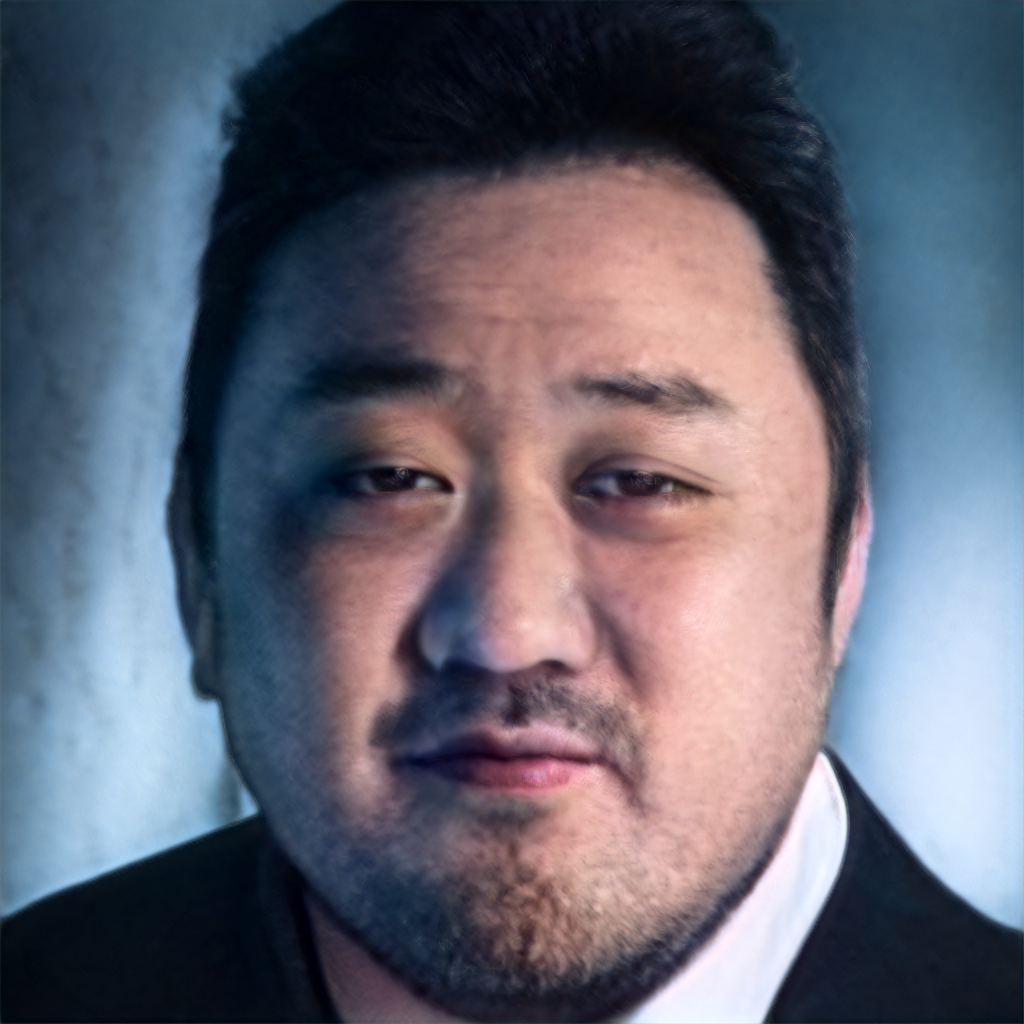

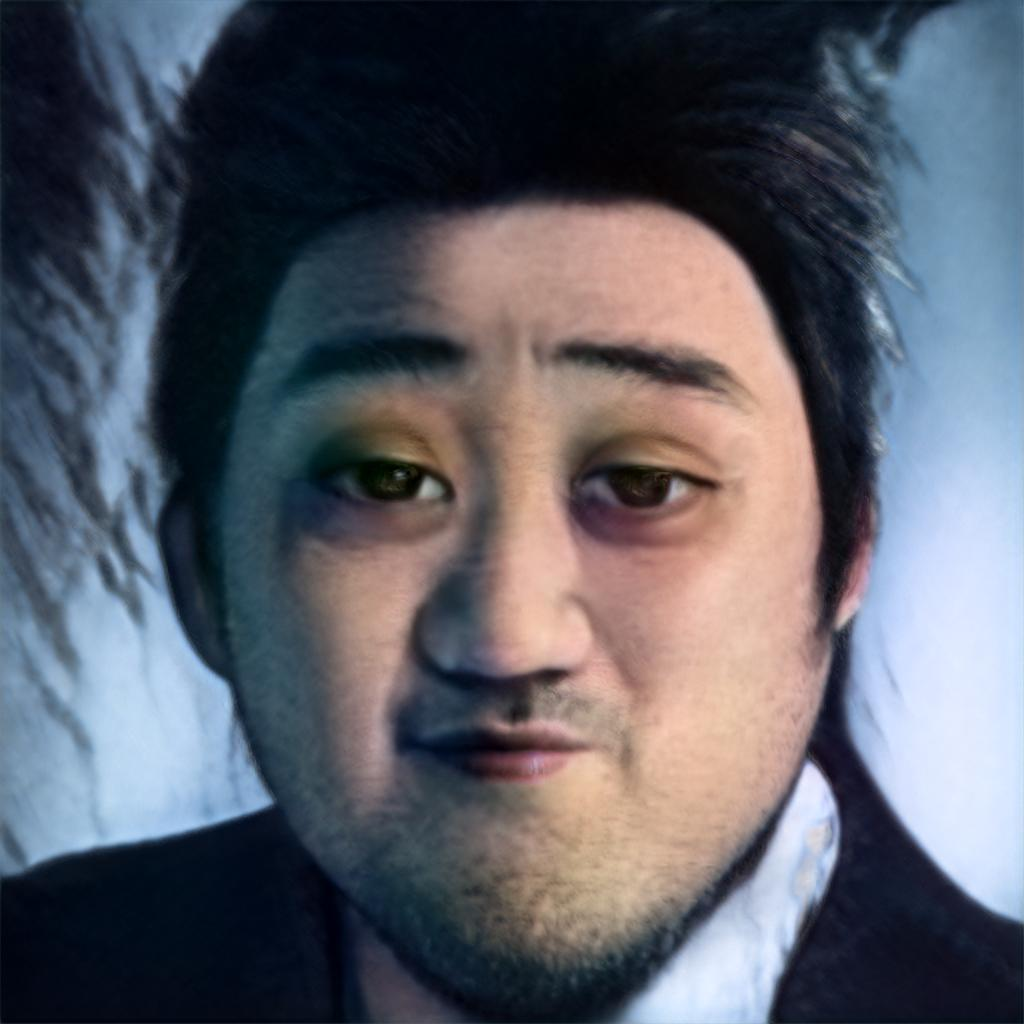

In [ ]:
from IPython.display import Image 
embedded = Image(filename="generated/example_01.png", width=256)
display(embedded)
tooned = Image(filename="generated/example_01-toon.jpg", width=256)
display(tooned)